In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.sparse.linalg
import scipy.linalg
import linear_solvers
from tqdm import tnrange

In this notebook, we will use several matrices from the University of Florida Sparse Matrix collection to test the different GMRES solvers. As a metric, we will effectively check the number of restarts needed to converge to a specific residual norm value.

In [3]:


# The cases to use in the analysis
case_files = ["Data/raefsky1.mat", "Data/add20.mat", "Data/orsreg_1.mat", 
              "Data/sherman1.mat", "Data/sherman4.mat", "Data/cavity05.mat",
              "Data/fpga_trans_01.mat", "Data/wang2.mat"]

case_file_names = ["raefsky1", "add20", "orsreg_1", "sherman1", "sherman4", 
                  "cavity05", "fpga_trans_01", "wang2"]


In [4]:

# A list to hold the convergence results corresponding to the cases 
# in the case_files list. 
case_results = []


In [5]:

# The GMRES parameters for the cases considered

# The parameters for the GMRES, GMRES-E and LGMRES solves
n_rst = 30

# The number of eigenvectors to use for GMRES-E (will use still a subspace
# of size n_rst for estimation)
k_gmres_e = 4   

# The number of error vectors to use for LGMRES (will use still a subspace of 
# size n_rst for estimation)
k_gmres_l = 4

# Desired accuracy (relative residual)
rel_r_tol = 1e-11



In [6]:

for case_file_i in tnrange(len(case_files)):
    
    case_file = case_files[case_file_i]
    
    case_data_dict = {}
    
    # Load the data
    input_data = scipy.io.loadmat(case_file)

    # The LHS Matrix
    A = input_data['Problem']['A'][0][0].toarray()

    # Create the RHS by making it a vector of ones
    b = np.ones((A.shape[0], 1))
    
    # The initial guess
    x0 = np.zeros(b.shape)
    
    # Standard GMRES
    (rel_r_conv_gmres, x_n_gmres, data_dict_gmres) = \
        linear_solvers.GMRES(A, b, x0, n_rst, resid_relative_tolerance=rel_r_tol, 
                             print_progress=False)
    
    
    case_data_dict['rel_r_conv_gmres'] = rel_r_conv_gmres
    case_data_dict['x_n_gmres'] = x_n_gmres
    
    # Check the residual angle during convergence to get an idea of
    # how well LGMRES would do
    (seq_angles, skip_angles) = \
        linear_solvers.residual_angle_convergence(data_dict_gmres['res_vecs_rst_convergence'])
    
    case_data_dict['median_seq_angles'] = np.median(seq_angles)
    case_data_dict['median_skip_angles'] = np.median(skip_angles)
    
    # Check the Normality metric
    normality_metric = linear_solvers.matrix_normality_metric(A)
    case_data_dict['normality_metric'] = normality_metric
    
    # Check the spectra
    w = np.linalg.eigvals(A)
    w_abs = np.abs(w)
    w_abs = np.sort(w_abs)
    
    kappa_e_init = w_abs[-1]/w_abs[0]
    kappa_e_modified = w_abs[-1]/w_abs[k_gmres_e]
    
    case_data_dict['kappa_e_init'] = kappa_e_init
    case_data_dict['kappa_e_modified'] = kappa_e_modified
    
    
    # GMRES-E Solve
    (rel_r_conv_gmres_e, x_n_gmres_e, data_dict_gmres_e) = \
        linear_solvers.GMRES_E(A, b, x0, n_rst-k_gmres_e, k_gmres_e, 
                             resid_relative_tolerance=rel_r_tol, print_progress=False)
    
    case_data_dict['rel_r_conv_gmres_e'] = rel_r_conv_gmres_e
    case_data_dict['x_n_gmres_e'] = x_n_gmres_e
    
    
    # LGMRES Solve
    (rel_r_conv_gmres_l, x_n_gmres_l, data_dict_gmres_l) = \
        linear_solvers.LGMRES(A, b, x0, n_rst-k_gmres_l, k_gmres_l, 
                             resid_relative_tolerance=rel_r_tol, print_progress=False)
    
    case_data_dict['rel_r_conv_gmres_l'] = rel_r_conv_gmres_l
    case_data_dict['x_n_gmres_l'] = x_n_gmres_l
    
    
    case_results.append(case_data_dict)
    


/Users/jm-034232/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """Entry point for launching an IPython kernel.


In [7]:

# Print the Median Skip and Sequential angles for the cases (for LGMRES analysis)

for i in range(len(case_files)):
    
    case_name = case_file_names[i]
    
    med_seq_angle = case_results[i]['median_seq_angles']
    med_skip_angle = case_results[i]['median_skip_angles']
    
    print("%s -> med_seq: %.2f, med_skip: %.2f" % (case_name, med_seq_angle, med_skip_angle))
    


raefsky1 -> med_seq: 26.33, med_skip: 8.29
add20 -> med_seq: 46.24, med_skip: 0.93
orsreg_1 -> med_seq: 67.81, med_skip: 32.52
sherman1 -> med_seq: 28.35, med_skip: 0.17
sherman4 -> med_seq: 64.77, med_skip: 10.42
cavity05 -> med_seq: 8.68, med_skip: 3.36
fpga_trans_01 -> med_seq: 23.33, med_skip: 0.18
wang2 -> med_seq: 34.75, med_skip: 7.10


In [8]:

# Print the Normality Metric and kappa change values (for GMRES-E Analysis)

for i in range(len(case_files)):
    
    case_name = case_file_names[i]
    
    normality_metric = case_results[i]['normality_metric']
    
    kappa_e_init = case_results[i]['kappa_e_init']
    kappa_e_modified = case_results[i]['kappa_e_modified']
    
    kappa_ratio = kappa_e_modified/kappa_e_init
    
    print("%s -> normality: %.3e, kappa_ratio: %.3e" % (case_name, normality_metric, kappa_ratio))
    


raefsky1 -> normality: 5.834e-03, kappa_ratio: 1.923e-02
add20 -> normality: 2.534e-07, kappa_ratio: 9.813e-01
orsreg_1 -> normality: 4.003e+06, kappa_ratio: 8.837e-01
sherman1 -> normality: 0.000e+00, kappa_ratio: 1.684e-01
sherman4 -> normality: 6.305e-01, kappa_ratio: 7.120e-02
cavity05 -> normality: 2.086e-01, kappa_ratio: 2.115e-02
fpga_trans_01 -> normality: 2.374e-05, kappa_ratio: 9.968e-01
wang2 -> normality: 2.065e-03, kappa_ratio: 9.788e-02


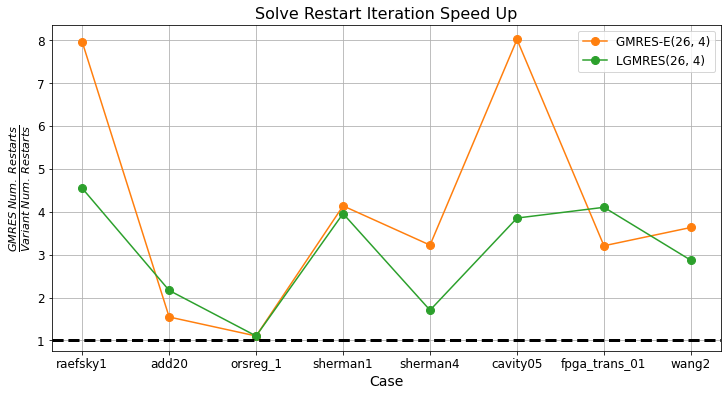

In [9]:

# Plot the speed up in restart iterations

# Store the ratio of GMRES/Variant number of iterations
restart_iters_ratio_gmres_e = []
restart_iters_ratio_lgmres = []

for case_result in case_results:
    
    gmres_n_restarts = len(case_result['rel_r_conv_gmres'])
    
    gmres_e_n_restarts = len(case_result['rel_r_conv_gmres_e'])
    lgmres_n_restarts = len(case_result['rel_r_conv_gmres_l'])
    
    restart_iters_ratio_gmres_e.append(gmres_n_restarts/gmres_e_n_restarts)
    restart_iters_ratio_lgmres.append(gmres_n_restarts/lgmres_n_restarts)

# Plot the speed up factors for the cases
plt.figure(figsize=(12,6))

plt.plot(restart_iters_ratio_gmres_e, marker="o", markersize=8, c="C1", label="GMRES-E(%d, %d)"%(n_rst-k_gmres_e, k_gmres_e))
plt.plot(restart_iters_ratio_lgmres, marker="o", markersize=8, c="C2", label="LGMRES(%d, %d)"%(n_rst-k_gmres_l, k_gmres_l))

plt.axhline(1.0, linestyle="--", c="k", linewidth=3)

plt.grid()

plt.xlabel("Case", fontsize=14)
plt.ylabel(r"$\frac{GMRES \; Num. \;Restarts}{Variant \; Num. \; Restarts}$", fontsize=16)

plt.title("Solve Restart Iteration Speed Up", fontsize=16)

ax = plt.gca()
ax.set_xticks(np.linspace(0,len(case_files)-1,len(case_files)))
ax.set_xticklabels(case_file_names, rotation='horizontal', fontsize=12)

plt.yticks(fontsize=12)

plt.legend(fontsize=12)

#plt.savefig("Results/Comparisons/speedup.pdf")


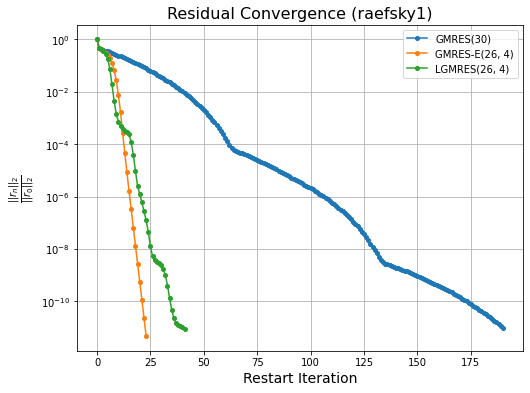

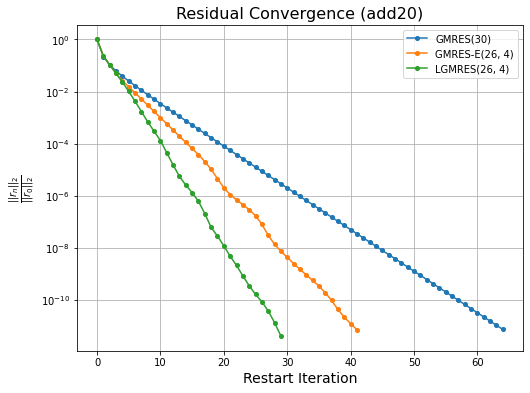

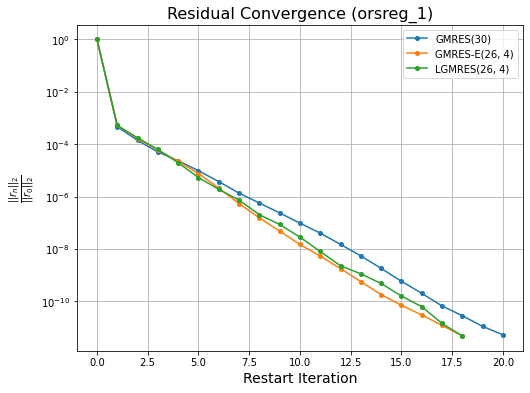

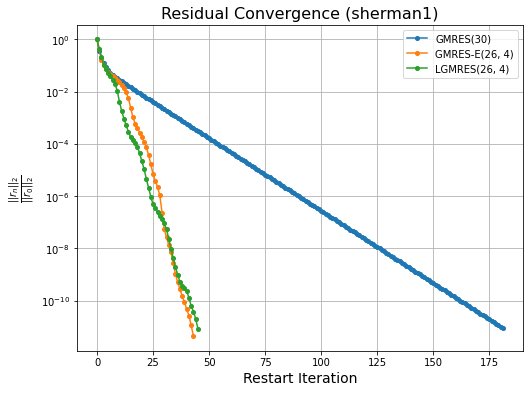

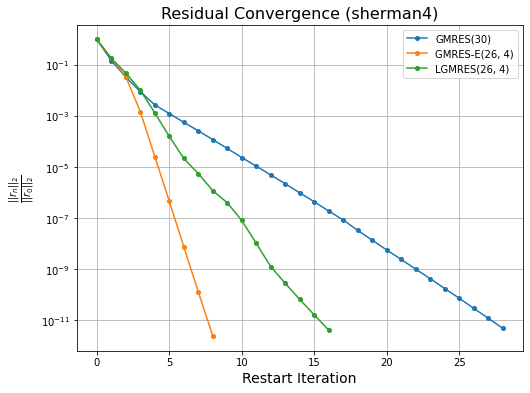

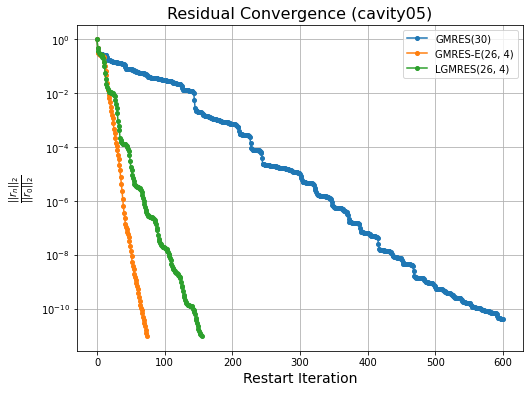

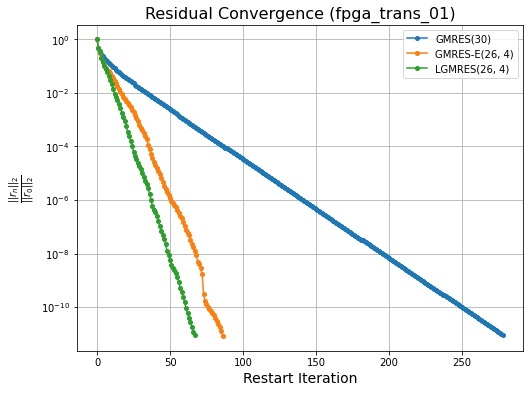

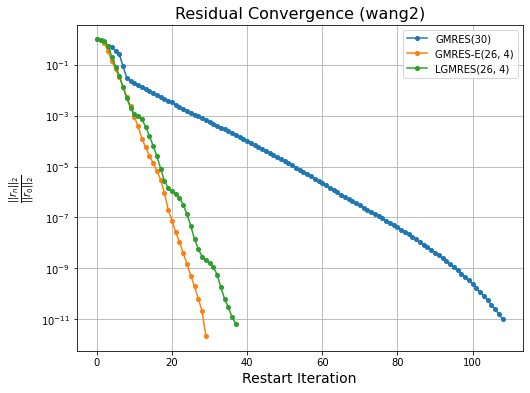

In [10]:
# Plot the Residual Convergence Results

for i in range(len(case_files)):
    
    plt.figure(figsize=(8,6))

    rel_r_conv_gmres = case_results[i]['rel_r_conv_gmres']
    rel_r_conv_gmres_e = case_results[i]['rel_r_conv_gmres_e']
    rel_r_conv_gmres_l = case_results[i]['rel_r_conv_gmres_l']
    
    case_name = case_file_names[i]
    
    plt.semilogy(rel_r_conv_gmres, marker='o', markersize=4, label="GMRES(%d)"%(n_rst))
    plt.semilogy(rel_r_conv_gmres_e, marker='o', markersize=4, label="GMRES-E(%d, %d)"%(n_rst-k_gmres_e, k_gmres_e))
    plt.semilogy(rel_r_conv_gmres_l, marker='o', markersize=4, label="LGMRES(%d, %d)"%(n_rst-k_gmres_l, k_gmres_l))

    plt.xlabel("Restart Iteration", fontsize=14)
    plt.ylabel(r"$\frac{||r_n||_2}{||r_0||_2}$", fontsize=14)

    plt.title("Residual Convergence (%s)" % (case_name), fontsize=16)

    plt.legend()

    plt.grid()
    
    #plt.savefig("Results/Comparisons/resid_conv_%s.pdf"%(case_name))
